---
## 1. Setup and Data Loading

In [13]:
# ============================================
# IMPORT LIBRARIES
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported")

✅ Libraries imported


In [14]:
# ============================================
# LOAD 2023 PREDICTION DATA
# ============================================

df_2023 = pd.read_csv('../data/processed/features_2023_predict.csv')

print(f"✅ Loaded 2023 data: {df_2023.shape[0]:,} rows")
print(f"📅 Year: {df_2023['Year'].unique()}")
print("\n⚠️ Note: This data has NO TARGET (answers don't exist yet)")

✅ Loaded 2023 data: 1,722 rows
📅 Year: [2023]

⚠️ Note: This data has NO TARGET (answers don't exist yet)


In [15]:
# ============================================
# LOAD MODELS AND PREPROCESSING ARTIFACTS
# ============================================

# Load preprocessing artifacts
scaler = joblib.load('../models/scaler.pkl')
feature_columns = joblib.load('../models/feature_columns.pkl')
train_medians = joblib.load('../models/train_medians.pkl')

# Load best model (Logistic Regression - 57.3% accuracy on 2022 holdout)
lr_model = joblib.load('../models/logistic_regression.pkl')

print("✅ Loaded models and preprocessing artifacts")
print("📊 Using Logistic Regression (best model: 57.3% accuracy)")

✅ Loaded models and preprocessing artifacts
📊 Using Logistic Regression (best model: 57.3% accuracy)


---
## 2. Prepare 2023 Features

In [16]:
# ============================================
# PREPARE 2023 FEATURES
# ============================================

# Apply same preprocessing as training
predict_data = df_2023.copy()

# Encode Division
division_map = {'D1': 3, 'D2': 2, 'D3': 1, 'Other': 0, 'Unknown': 0}
predict_data['Division_Encoded'] = predict_data['Division'].map(division_map).fillna(0)

# Extract features
X_2023 = predict_data[feature_columns].copy()

# Handle missing/infinite values (using TRAINING medians)
X_2023 = X_2023.replace([np.inf, -np.inf], np.nan)
X_2023 = X_2023.fillna(train_medians)

# Scale (using TRAINING scaler)
X_2023_scaled = scaler.transform(X_2023)

print(f"✅ 2023 data prepared: {X_2023_scaled.shape}")

✅ 2023 data prepared: (1722, 14)


---
## 3. Generate Predictions

In [17]:
# ============================================
# GENERATE PREDICTIONS
# ============================================

# Get class predictions
predictions = lr_model.predict(X_2023_scaled)

# Get probability scores
probabilities = lr_model.predict_proba(X_2023_scaled)

# Map numeric predictions to class names
class_names = {0: 'Declining', 1: 'Stable', 2: 'Improving'}
predicted_labels = [class_names[p] for p in predictions]

print("✅ Predictions generated")
print(f"\n📊 Prediction Distribution:")
pred_counts = pd.Series(predicted_labels).value_counts()
for label, count in pred_counts.items():
    pct = count / len(predicted_labels) * 100
    print(f"   {label}: {count:,} ({pct:.1f}%)")

✅ Predictions generated

📊 Prediction Distribution:
   Stable: 951 (55.2%)
   Improving: 540 (31.4%)
   Declining: 231 (13.4%)


In [18]:
# ============================================
# CREATE PREDICTIONS DATAFRAME
# ============================================

# Create comprehensive predictions DataFrame
predictions_df = pd.DataFrame({
    'UNITID': df_2023['UNITID'],
    'Institution_Name': df_2023['Institution_Name'],
    'State': df_2023['State'],
    'Division': df_2023['Division'],
    'Year': df_2023['Year'],
    'Predicted_Trajectory': predicted_labels,
    'Confidence_Declining': probabilities[:, 0],
    'Confidence_Stable': probabilities[:, 1],
    'Confidence_Improving': probabilities[:, 2]
})

# Add max confidence score
predictions_df['Confidence_Score'] = probabilities.max(axis=1)

print("✅ Predictions DataFrame created")
print(f"\n📋 Sample predictions:")
print(predictions_df[['Institution_Name', 'Predicted_Trajectory', 'Confidence_Score']].head(10))

✅ Predictions DataFrame created

📋 Sample predictions:
                         Institution_Name Predicted_Trajectory  \
0                Alabama A & M University               Stable   
1     University of Alabama at Birmingham            Improving   
2     University of Alabama in Huntsville               Stable   
3                Alabama State University               Stable   
4               The University of Alabama            Declining   
5       Central Alabama Community College               Stable   
6         Auburn University at Montgomery            Improving   
7                       Auburn University            Improving   
8  Chattahoochee Valley Community College            Improving   
9      Enterprise State Community College               Stable   

   Confidence_Score  
0          0.438196  
1          0.461385  
2          0.476658  
3          0.489801  
4          0.825915  
5          0.398115  
6          0.524050  
7          0.498055  
8          0.578285 

---
## 4. Analyze Predictions

In [19]:
# ============================================
# PREDICTIONS BY DIVISION
# ============================================

print("📊 PREDICTIONS BY DIVISION:")
print("="*60)

div_preds = predictions_df.groupby(['Division', 'Predicted_Trajectory']).size().unstack(fill_value=0)
div_preds_pct = div_preds.div(div_preds.sum(axis=1), axis=0) * 100

print(div_preds_pct.round(1))

📊 PREDICTIONS BY DIVISION:
Predicted_Trajectory  Declining  Improving  Stable
Division                                          
D1                         31.8       17.5    50.7
D2                          8.6       36.4    55.0
D3                         12.0       32.2    55.9
Other                       7.1       35.7    57.1


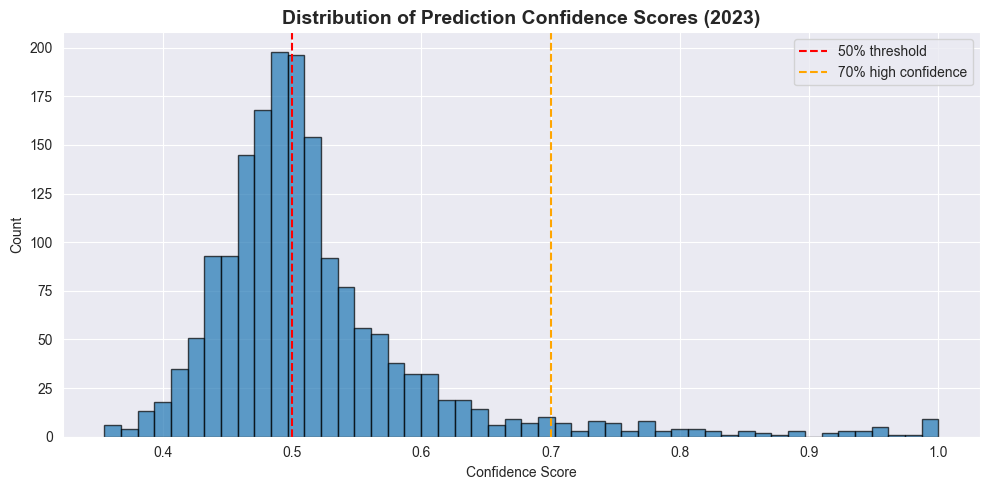


✅ Figure saved to ../reports/confidence_distribution.png


In [20]:
# ============================================
# CONFIDENCE DISTRIBUTION
# ============================================

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(predictions_df['Confidence_Score'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(x=0.5, color='red', linestyle='--', label='50% threshold')
ax.axvline(x=0.7, color='orange', linestyle='--', label='70% high confidence')

ax.set_xlabel('Confidence Score')
ax.set_ylabel('Count')
ax.set_title('Distribution of Prediction Confidence Scores (2023)', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('../reports/confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved to ../reports/confidence_distribution.png")

In [21]:
# ============================================
# HIGH-CONFIDENCE PREDICTIONS
# ============================================

high_conf_threshold = 0.7
high_conf = predictions_df[predictions_df['Confidence_Score'] >= high_conf_threshold]

print(f"\n📊 HIGH-CONFIDENCE PREDICTIONS (>={high_conf_threshold:.0%}):")
print("="*60)
print(f"Total: {len(high_conf):,} / {len(predictions_df):,} ({len(high_conf)/len(predictions_df)*100:.1f}%)")

print("\n🔴 Top institutions predicted DECLINING:")
declining_conf = high_conf[high_conf['Predicted_Trajectory'] == 'Declining'].nlargest(5, 'Confidence_Score')
for _, row in declining_conf.iterrows():
    print(f"   {row['Institution_Name']}: {row['Confidence_Score']:.1%}")

print("\n🟢 Top institutions predicted IMPROVING:")
improving_conf = high_conf[high_conf['Predicted_Trajectory'] == 'Improving'].nlargest(5, 'Confidence_Score')
for _, row in improving_conf.iterrows():
    print(f"   {row['Institution_Name']}: {row['Confidence_Score']:.1%}")


📊 HIGH-CONFIDENCE PREDICTIONS (>=70%):
Total: 85 / 1,722 (4.9%)

🔴 Top institutions predicted DECLINING:
   Pacific Union College: 100.0%
   Vermont State University: 100.0%
   University of Rio Grande: 100.0%
   Baton Rouge Community College: 100.0%
   Gordon College: 99.9%

🟢 Top institutions predicted IMPROVING:
   Bethel University: 99.9%
   Rust College: 99.7%
   Rockland Community College: 98.3%
   Southern Crescent Technical College: 95.7%
   Ulster County Community College: 95.3%


---
## 5. Visualize Predictions

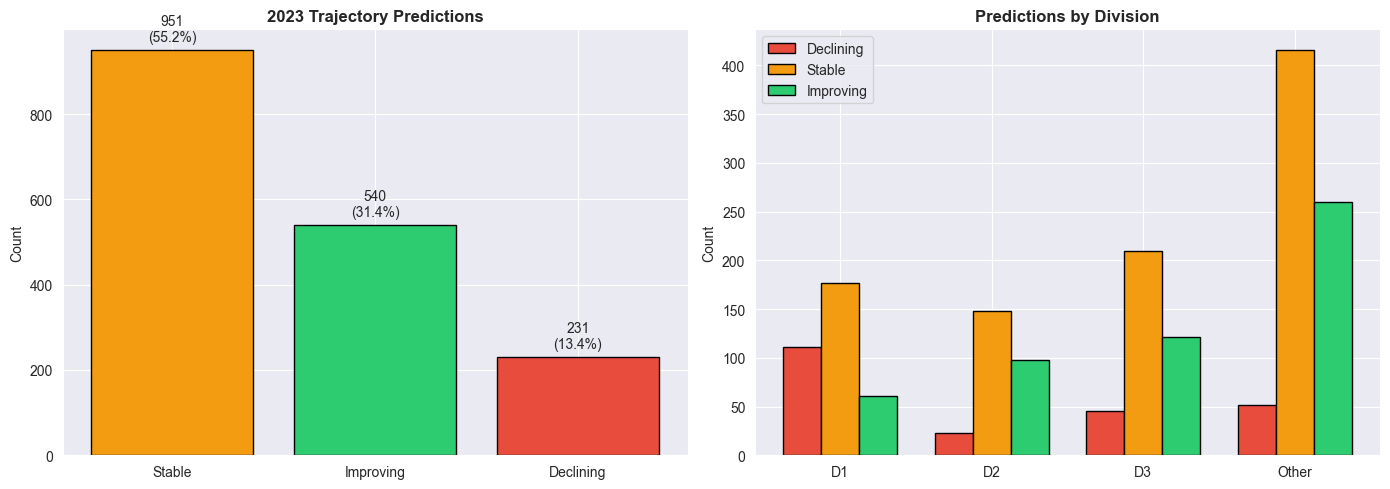


✅ Figure saved to ../reports/predictions_2023_visualization.png


In [26]:
# ============================================
# PREDICTION DISTRIBUTION
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
pred_counts = predictions_df['Predicted_Trajectory'].value_counts()
colors = {'Declining': '#e74c3c', 'Stable': '#f39c12', 'Improving': '#2ecc71'}
bar_colors = [colors[p] for p in pred_counts.index]

axes[0].bar(pred_counts.index, pred_counts.values, color=bar_colors, edgecolor='black')
for i, (label, count) in enumerate(pred_counts.items()):
    axes[0].text(i, count + 20, f'{count:,}\n({count/len(predictions_df)*100:.1f}%)', 
                 ha='center', fontsize=10)
axes[0].set_ylabel('Count')
axes[0].set_title('2023 Trajectory Predictions', fontsize=12, fontweight='bold')

# By Division - only show divisions with data (D1 and Other)
div_order = ['D1','D2','D3', 'Other']
pred_order = ['Declining', 'Stable', 'Improving']

x = np.arange(len(div_order))
width = 0.25

for i, pred in enumerate(pred_order):
    counts = [len(predictions_df[(predictions_df['Division'] == d) & 
                                  (predictions_df['Predicted_Trajectory'] == pred)]) 
              for d in div_order]
    axes[1].bar(x + i*width, counts, width, label=pred, color=colors[pred], edgecolor='black')

axes[1].set_xticks(x + width)
axes[1].set_xticklabels(div_order)
axes[1].set_ylabel('Count')
axes[1].set_title('Predictions by Division', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/predictions_2023_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved to ../reports/predictions_2023_visualization.png")

---
## 6. Save Predictions

In [23]:
# ============================================
# SAVE PREDICTIONS
# ============================================

# Save full predictions
predictions_df.to_csv('../reports/predictions_2023.csv', index=False)
print("✅ Saved predictions to ../reports/predictions_2023.csv")

# Save high-confidence predictions separately
high_conf.to_csv('../reports/predictions_2023_high_confidence.csv', index=False)
print("✅ Saved high-confidence predictions to ../reports/predictions_2023_high_confidence.csv")

✅ Saved predictions to ../reports/predictions_2023.csv
✅ Saved high-confidence predictions to ../reports/predictions_2023_high_confidence.csv


---
## 7. Final Summary

In [24]:
# ============================================
# PREDICTION SUMMARY
# ============================================

summary = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                          2023 PREDICTIONS COMPLETE                           ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  PREDICTIONS GENERATED:                                                      ║
║  ─────────────────────────                                                   ║
║  • Total institutions: {len(predictions_df):,}                                            ║
║  • Year: 2023                                                                ║
║  • Model: Logistic Regression (best model: 57.3% accuracy)                  ║
║                                                                              ║
║  PREDICTION DISTRIBUTION:                                                    ║
║  ────────────────────────                                                    ║
║  • Declining:  {(predictions_df['Predicted_Trajectory'] == 'Declining').sum():,} ({(predictions_df['Predicted_Trajectory'] == 'Declining').mean()*100:.1f}%)                                           ║
║  • Stable:     {(predictions_df['Predicted_Trajectory'] == 'Stable').sum():,} ({(predictions_df['Predicted_Trajectory'] == 'Stable').mean()*100:.1f}%)                                           ║
║  • Improving:  {(predictions_df['Predicted_Trajectory'] == 'Improving').sum():,} ({(predictions_df['Predicted_Trajectory'] == 'Improving').mean()*100:.1f}%)                                           ║
║                                                                              ║
║  CONFIDENCE STATISTICS:                                                      ║
║  ──────────────────────                                                      ║
║  • High confidence (≥70%): {len(high_conf):,} predictions                              ║
║  • Mean confidence: {predictions_df['Confidence_Score'].mean():.1%}                                              ║
║  • Max confidence: {predictions_df['Confidence_Score'].max():.1%}                                               ║
║                                                                              ║
║  IMPORTANT NOTES:                                                            ║
║  ─────────────────                                                           ║
║  • These are TRUE predictions — no answers exist yet                         ║
║  • Validation would require 2024 financial data                              ║
║  • Use confidence scores to prioritize interventions                         ║
║                                                                              ║
║  SAVED FILES:                                                                ║
║  ─────────────                                                               ║
║  • ../reports/predictions_2023.csv                                           ║
║  • ../reports/predictions_2023_high_confidence.csv                           ║
║  • ../reports/predictions_2023_visualization.png                             ║
║  • ../reports/confidence_distribution.png                                    ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝

REMAINING TASKS:
→ Create leakage_check.ipynb (standalone verification)
→ Write README.md (project overview)
→ Write Report.md (comprehensive findings)
"""

print(summary)


╔══════════════════════════════════════════════════════════════════════════════╗
║                          2023 PREDICTIONS COMPLETE                           ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  PREDICTIONS GENERATED:                                                      ║
║  ─────────────────────────                                                   ║
║  • Total institutions: 1,722                                            ║
║  • Year: 2023                                                                ║
║  • Model: Logistic Regression (best model: 57.3% accuracy)                  ║
║                                                                              ║
║  PREDICTION DISTRIBUTION:                                                    ║
║  ────────────────────────                                                    ║
║  • Declining:  231 (13.4%)     

---
## ✅ Checkpoint Complete

We've generated **true predictions** for 2023:
1. Predicted financial trajectory for all institutions
2. Calculated confidence scores
3. Identified high-confidence predictions
4. Saved all results

**Key Point:** These predictions cannot be validated until 2024 data becomes available.

**Remaining Tasks:**
- `leakage_check.ipynb` — Standalone verification notebook
- `README.md` — Project overview and navigation
- `Report.md` — Comprehensive findings report